# SAE Data Mining : Colin David Ruth et Thibault
        
### Contexte
**Dans le cadre de cette SAE nous nous sommes appuyés sur le TP noté précédemment réalisé.**  
Nous avons constaté que le projet précédent impliquait de nombreux copier-coller ce qui limitait la flexibilité du code. Cela nous a amenés à repenser la structure du projet pour **faciliter les tests de différentes hypothèses et configurations**.  
Notre objectif était donc de concevoir une **architecture de code à la fois flexible et compréhensible**.

---
        
### Approche Adoptée
Pour répondre à ces besoins nous avons opté pour une **approche orientée objet** permettant de mieux répartir les tâches et de travailler de manière indépendante.Nous avons structuré le projet autour de **quatre classes principales** :  
        
1. **Data**: Gère l'importation la transformation et la vectorisation des données.
        
2. **Classifieur**: Regroupe les fonctionnalités communes à tous les classifieurs.
        
3. **Les différents classifieurs**: Héritent de la classe *Classifieur* pour implémenter les spécificités de chaque modèle.
        
4. **Projet**: Centralise les tests en explorant les hyperparamètres de la classe *Data* ainsi que ceux des différents classifieurs.
        
---
        
### Bénéfices
Cette structure nous a permis :  
- D’optimiser l'organisation du projet
- De faciliter l'exploration et l’expérimentation
- Et de rendre le code plus modulaire et accessible pour toute l'équipe.

## Import des bibliothèques nécessaires

In [ ]:
# Importations standard
import json
import re
import copy
from datetime import datetime
import os
import seaborn as sns

# Importations de bibliothèques tierces
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# Importations des modules sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import confusion_matrix

# Importations nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# Vérifier et télécharger les ressources nltk si nécessaires
nltk_resources = ['stopwords', 'punkt', 'wordnet']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
    except LookupError:
        nltk.download(resource)
nltk.download('punkt_tab')

## Classe Data pour tous les prétraitements, la vectorisation et la réduction de la matrice.

In [2]:
class Data:
    def __init__(self, data = "train.jsonl", test= False, limit=5000, language="french", text_column="texte_annonce"):
        if test==True:
            self.data = (pd.read_json("test.jsonl", lines=True)[["texte_annonce","OGC_FID"]])
        else:
            self.data = (pd.read_json("train.jsonl", lines=True, encoding="UTF-8")[["texte_annonce", "cal_réponse_signalement"]]).iloc[:limit]
            self.data["cal_réponse_signalement"] = self.data["cal_réponse_signalement"].map({"Pris en compte": 0,"Rejete (hors specs)": 1})
        self.text_column = text_column
        self.language = language


    def get_data(self):
        return self.data

    def supprimer_stopwords(self):
        stop_words = stopwords.words(self.language)

        def nettoyer_texte(texte):
            texte = re.sub(r'[^\w\s]', '', texte)  # Retirer la ponctuation
            texte = re.sub(r'\d+', '', texte)      # Retirer les chiffres
            tokens = nltk.word_tokenize(texte.lower())
            return ' '.join([word for word in tokens if word not in stop_words])

        # Appliquer la fonction de nettoyage à la colonne texte
        self.data[self.text_column] = self.data[self.text_column].apply(nettoyer_texte)

    def rien(self, x):
        pass

    def racinisation(self, ignore_stopwords=None):
        stemmer = SnowballStemmer(self.language)
        self.data[self.text_column] = self.data[self.text_column].apply(lambda x: ' '.join([stemmer.stem(word) for word in str(x).split()]))
        self.supprimer_stopwords()

    def lemmatisation(self, mode=None, overwrite=None):
        lemmatizer = WordNetLemmatizer()
        if mode:
            lemmatizer.mode = mode
        if overwrite:
            lemmatizer.overwrite = overwrite
        self.data[self.text_column] = self.data[self.text_column].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in str(x).split()]))
        self.supprimer_stopwords()

    def vectorisation_simple(self, ngram_range=None, max_features=None):
        vectorizer = CountVectorizer()
        if ngram_range:
            vectorizer.ngram_range = ngram_range
        if max_features:
            vectorizer.max_features = max_features
        vect_data = vectorizer.fit_transform(self.data[self.text_column])
        vect_df = pd.DataFrame(vect_data.toarray(), columns=vectorizer.get_feature_names_out())
        self.data = pd.concat([vect_df, self.data.iloc[:, -1]], axis=1)

    def vectorisation_ponderee(self, ngram_range=None, max_features=None, norm=None):
        vectorizer = TfidfVectorizer()
        if ngram_range:
            vectorizer.ngram_range = ngram_range
        if max_features:
            vectorizer.max_features = max_features
        if norm:
            vectorizer.norm = norm
        vect_data = vectorizer.fit_transform(self.data[self.text_column])
        vect_df = pd.DataFrame(vect_data.toarray(), columns=vectorizer.get_feature_names_out())
        self.data = pd.concat([vect_df, self.data.iloc[:, -1]], axis=1)

    def reduction_svd(self, n_components=50, n_iter=None):
        svd = TruncatedSVD()           
        if n_iter:
            svd.n_iter = n_iter
        svd = TruncatedSVD(n_components=n_components)
        svd_result = svd.fit_transform(self.data.iloc[:, :-1])
        self.data = pd.concat([pd.DataFrame(svd_result), self.data.iloc[:, -1]], axis=1)

    def reduction_nmf(self, n_components=50, init=None):
        nmf = NMF(n_components=n_components)
        if init:
            nmf.init = init
        nmf_result = nmf.fit_transform(self.data.iloc[:, :-1])
        self.data = pd.concat([pd.DataFrame(nmf_result), self.data.iloc[:, -1]], axis=1)



## Classe de base des classifieurs permettant l'héritage

In [3]:
class Classifieur:
    def __init__(self, data):
        # Chargement et découpage des données
        self.chargement(data)
        self.decoupage()

    def chargement(self, data):
        # Chargement des données et séparation X, y
        self.data = data
        self.X = data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière (X)
        self.y = data.iloc[:, -1]   # Dernière colonne (y)

    def decoupage(self):
        # Découpage en jeu d'entrainement et test
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X, self.y, test_size=0.6, random_state=0)

    def entrainement(self):
        pass

    def rien(self):
        pass

    def taux_reussite(self):
        # Calcul du taux de réussite
        y_pred = self.classifier.predict(self.X_test)
        accuracy = accuracy_score(self.Y_test, y_pred)
        return f"{accuracy:.3f}"

    def f1_score(self, graph = False):
        # Calcul du F1-score
        from sklearn.metrics import f1_score
        import seaborn as sns
        y_pred = self.classifier.predict(self.X_test)
        f1 = f1_score(self.Y_test, y_pred, average='weighted')

        if graph:
            cm = confusion_matrix(self.Y_test, y_pred)
            
            # Affichage avec seaborn
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.classifier.classes_, yticklabels=self.classifier.classes_)
            plt.title('Matrice de Confusion')
            plt.xlabel('Prédictions')
            plt.ylabel('Vérités')
            plt.show()

        return f"{f1:.3f}"

    def recherche_hyperparametres(self,param_grid):
          # Recherche des meilleurs hyperparamètres avec GridSearchCV
          grid_search = GridSearchCV(
              self.classifier,
              param_grid,
              cv=5,  # Validation croisée 5-fold
              scoring='f1',
          )
          grid_search.fit(self.X_train, self.Y_train) # tres important de preciser le label posit
          self.classifier = grid_search.best_estimator_ # Automatiquement garde le meilleur classifieur
          return grid_search.best_params_
    
    def predict(self, data):
        X = data.iloc[:, :-1]  
        ogc = data.iloc[:, -1] 

        y_pred = self.classifier.predict(X)  
        y_pred = pd.Series(y_pred, name="cal_réponse_signalement")
        y_pred = y_pred.map({0: "Pris en compte", 1: "Rejeté (hors specs)"})

        result = pd.concat([ogc, y_pred], axis=1)
        result.to_csv("submission.csv", index=False)

        return result


In [4]:
from sklearn.naive_bayes import MultinomialNB


class Multinomial(Classifieur):
    def __init__(self, data, alpha = None, fit_prior = None):
        super().__init__(data)
        self.classifier = MultinomialNB()
        if alpha : self.classifier.alpha = alpha
        if fit_prior : self.classifier.fit_prior = fit_prior

    def entrainement(self):
        # Entraînement du modèle avec les données
        self.classifier.fit(self.X_train, self.Y_train)


In [5]:
from sklearn.naive_bayes import BernoulliNB


class Bernoulli(Classifieur):
    def __init__(self, data, alpha = None, fit_prior = None, binarize = None):
        super().__init__(data)

        self.classifier = BernoulliNB()
        if alpha : self.classifier.alpha = alpha
        if fit_prior : self.classifier.fit_prior = fit_prior
        if binarize : self.classifier.binarize = binarize


    def entrainement(self):
        # Entraînement du modèle avec les données
        self.classifier.fit(self.X_train, self.Y_train)

In [6]:
from sklearn.naive_bayes import GaussianNB


class Gaussian(Classifieur):
    def __init__(self, data, var_smoothing = None):
        super().__init__(data)
        self.classifier = GaussianNB()
        if var_smoothing : self.classifier.var_smoothing = var_smoothing

    def entrainement(self):
        # Entraînement du modèle avec les données
        self.classifier.fit(self.X_train, self.Y_train)

In [7]:
from sklearn.linear_model import LogisticRegression

class RegressionLogistique(Classifieur):
    def __init__(self, data, penalty = None, C = None, solver = None, max_iter = None, l1_ratio = None, random_state = None):
        super().__init__(data)
        self.classifier = LogisticRegression()
        if penalty : self.classifier.penalty = penalty
        if C : self.classifier.C = C
        if solver : self.classifier.solver = solver
        if max_iter : self.classifier.max_iter = max_iter
        if l1_ratio : self.classifier.l1_ratio
        if random_state : self.classifier.random_state = random_state

    def entrainement(self):
        self.classifier.fit(self.X_train, self.Y_train)


In [8]:
from sklearn.neighbors import KNeighborsClassifier

class KPlusProchesVoisins(Classifieur):
    def __init__(self, data, n_neighbors = 3, weights = None, algorithm = None, p = None):
        super().__init__(data)

        self.classifier = KNeighborsClassifier()
        if n_neighbors : self.classifier.n_neighbors = n_neighbors
        if weights : self.classifier.weights = weights
        if algorithm : self.classifier.algorithm = algorithm
        if p : self.classifier.p = p

    def entrainement(self):
        self.classifier.fit(self.X_train, self.Y_train)


In [9]:
from sklearn.tree import DecisionTreeClassifier

class ArbreDeDecision(Classifieur):
    def __init__(self, data, criterion = None, max_depth = None, min_samples_split = None, min_samples_leaf = None, max_features = None, ccp_alpha = None, random_state = None):
        super().__init__(data)
        self.classifier = DecisionTreeClassifier()
        if criterion : self.classifier.criterion = criterion
        if max_depth : self.classifier.max_depth = max_depth
        if min_samples_split : self.classifier.min_samples_split = min_samples_split
        if min_samples_leaf : self.classifier.min_samples_leaf = min_samples_leaf
        if max_features : self.classifier.max_features = max_features
        if ccp_alpha : self.classifier.ccp_alpha = ccp_alpha
        if random_state : self.classifier.random_state = random_state

    def entrainement(self):
        self.classifier.fit(self.X_train, self.Y_train)


In [10]:
from sklearn.ensemble import RandomForestClassifier

class ForetAleatoire(Classifieur):
    def __init__(self, data, n_estimators = 100, criterion = None, max_depth = None, min_samples_split = None, min_samples_leaf = None, max_features = None, bootstrap = None, ccp_alpha = None, random_state = 0 ):
        super().__init__(data)
        self.classifier = RandomForestClassifier()
        if n_estimators : self.classifier.n_estimators = n_estimators
        if criterion : self.classifier.criterion = criterion
        if max_depth : self.classifier.max_depth = max_depth
        if min_samples_split : self.classifier.min_samples_split = min_samples_split
        if min_samples_leaf : self.classifier.min_samples_leaf = min_samples_leaf
        if max_features : self.classifier.max_features = max_features
        if bootstrap : self.classifier.bootstrap = bootstrap
        if ccp_alpha : self.classifier.ccp_alpha = ccp_alpha
        if random_state : self.classifier.random_state = random_state

    def entrainement(self):
        self.classifier.fit(self.X_train, self.Y_train)


## Classe Projet intégrant les classes précédentes

In [11]:
class Projet() :
    def __init__(self, sequence_data, sequence_classifieur, data_json = "train.jsonl", limit_data = 100, json_resultat = "json_résultat"):

        self.valider_nomenclature(sequence_data, sequence_classifieur)

        

        self.sequence_data = sequence_data
        self.sequence_classifieur = sequence_classifieur
        self.data_json = data_json 
        self.limit_data = limit_data
        self.json_resultat = json_resultat


        self.verif_json_reslutat_name()


        with open("hyperpamètres_classifieur.jsonl","r") as file_1:
            self.hyper_classifieur = json.load(file_1)
        with open("hyperparametres_traitement.jsonl", "r") as file_2:
            self.hyper_data = json.load(file_2)


        if self.sequence_data["vectorisation_simple"] == False and self.sequence_data["vectorisation_ponderee"] == False : self.sequence_data["vectorisation_simple"] = True
        

        ### COMBINAISON DES DATA POSSIBLES ###
        self.combo_data = self.generate_data_hyperparam_combinations()
        self.nb_combo_data = len(self.combo_data)

        print(self.nb_combo_data)

        self.etape_1_sauv = {}
        self.etape_1_2_sauv = {}
        self.etape_1_2_3_sauv = {}
        self.final_res = {}

        self.main_loop()

    def main_loop(self):

        for combinaison in self.combo_data : 
            self.data = Data(data=self.data_json, limit = self.limit_data)
            preprocessing_str = json.dumps(combinaison["preprocessing"], ensure_ascii=False)
            vectorization_str = json.dumps(combinaison["vectorization"], ensure_ascii=False)
            dimension_reduction = json.dumps(combinaison["dimension_reduction"], ensure_ascii=False)
            etape_1_2_str = preprocessing_str + "," + vectorization_str
            etape_1_2_3_str = preprocessing_str + "," + vectorization_str + "," + dimension_reduction


            if etape_1_2_3_str in self.etape_1_2_3_sauv : 
                self.data = copy.deepcopy(self.etape_1_2_3_sauv[etape_1_2_3_str])



            if etape_1_2_str in self.etape_1_2_sauv and etape_1_2_3_str not in self.etape_1_2_3_sauv: 
                self.data = copy.deepcopy(self.etape_1_2_sauv[etape_1_2_str])
                print(self.data.get_data())
                self.apply_etape_3(combinaison["dimension_reduction"], etape_1_2_3_str)

            if (etape_1_2_str not in self.etape_1_2_sauv) and (preprocessing_str in self.etape_1_sauv) and (etape_1_2_3_str not in self.etape_1_2_3_sauv): 
                self.data = copy.deepcopy(self.etape_1_sauv[preprocessing_str])
                self.apply_etape_2(combinaison["vectorization"], etape_1_2_str)
                self.apply_etape_3(combinaison["dimension_reduction"], etape_1_2_3_str)
            
            if etape_1_2_str not in self.etape_1_2_sauv and preprocessing_str not in self.etape_1_sauv and etape_1_2_3_str not in self.etape_1_2_3_sauv:
                self.apply_etape_1(combinaison["preprocessing"], preprocessing_str)
                self.apply_etape_2(combinaison["vectorization"], etape_1_2_str)
                self.apply_etape_3(combinaison["dimension_reduction"], etape_1_2_3_str)


            self.data = self.data.get_data()

            for classifieur_type, booleen_classifier in self.sequence_classifieur.items() : 
                if booleen_classifier : 
                    classifieur = classifieur_type(self.data)
                    classifieur_name = classifieur.__class__.__name__
                    param_classifieur = self.hyper_classifieur[classifieur_name]
                    best_param = classifieur.recherche_hyperparametres(param_classifieur)
                    self.mise_en_forme_final_export_json(combinaison["preprocessing"], combinaison["vectorization"], combinaison["dimension_reduction"], classifieur_name, best_param, classifieur.f1_score())
                    nom_final = preprocessing_str + "," + vectorization_str + "," + dimension_reduction + "," + classifieur_name + "," + json.dumps(param_classifieur, ensure_ascii=False)
                    self.final_res[nom_final] = classifieur.f1_score()



    def mise_en_forme_final_export_json(self, preprocessing, vectorization, dimension_reduction, classifieur_name, best_param, f1_score):
        res = {
            "preprocessing" : preprocessing,
            "vectorization" : vectorization, 
            "dimension_reduction" : dimension_reduction,
            "classifieur_name" : classifieur_name,
            "best_param" : best_param, 
            "f1_score" : f1_score
        }


        if not os.path.exists(self.json_resultat):
            with open(self.json_resultat, 'w', encoding='utf-8') as fichier:
                json.dump([], fichier)

        with open(self.json_resultat, 'r', encoding='utf-8') as fichier:
                data_json_resultat = json.load(fichier)

        data_json_resultat.append(res)

        with open(self.json_resultat, 'w', encoding='utf-8') as fichier:
            json.dump(data_json_resultat, fichier, indent=4, ensure_ascii=False)


        


    def verif_json_reslutat_name(self):
        if os.path.exists(self.json_resultat):
            date_heure_actuelle = datetime.now()
            date_heure_chaine = date_heure_actuelle.strftime("%d-%m %H:%M:%S")
            date_heure_transformee = date_heure_chaine.replace(":", "-").replace(" ", "-")
            self.json_resultat = self.json_resultat + " " + date_heure_transformee
            return 
        else:
            return True  


    def apply_etape_1(self,param, nom):

        if param == None : return 

        if param["method"] == "racinisation" : 
            self.data.racinisation(ignore_stopwords = param["parameters"]["ignore_stopwords"])

        if param["method"] == "lemmatisation" : 
            self.data.lemmatisation(mode = param["parameters"]["mode"], overwrite = param["parameters"]["overwrite"])

        self.etape_1_sauv[nom] = copy.deepcopy(self.data)

    def apply_etape_2(self,  param, nom):
        if param == None : return 

        if param["method"] == "vectorisation_simple" :
            self.data.vectorisation_simple(ngram_range = tuple(param["parameters"]["ngram_range"]), max_features = param["parameters"]["max_features"])
        if param["method"] == "vectorisation_ponderee" : 
            self.data.vectorisation_ponderee(ngram_range = tuple(param["parameters"]["ngram_range"]), max_features = param["parameters"]["max_features"], norm = param["parameters"]["norm"])

        self.etape_1_2_sauv[nom] = copy.deepcopy(self.data)

    def apply_etape_3(self, param, nom):

        if param == None : return 

        if param["method"] == "reduction_svd" : 
            self.data.reduction_svd(n_components = param["parameters"]["n_components"])
        
        if param["method"] == "reduction_nmf" : 
            self.data.reduction_nmf(n_components = param["parameters"]["n_components"], init = param["parameters"]["init"])
        
        self.etape_1_2_3_sauv[nom + "," + json.dumps(param, ensure_ascii=False)] = copy.deepcopy(self.data)



    def generate_data_hyperparam_combinations(self):
        all_combinations = []

        preprocessing_steps = self.hyper_data.get("preprocessing", {})
        vectorization_steps = self.hyper_data.get("vectorization", {})
        reduction_steps = self.hyper_data.get("dimension_reduction", {})

        # Check if all methods for an entire step are disabled
        if not any(self.sequence_data.get(step, False) for step in preprocessing_steps):
            preprocessing_steps = {}
        if not any(self.sequence_data.get(step, False) for step in vectorization_steps):
            vectorization_steps = {}
        if not any(self.sequence_data.get(step, False) for step in reduction_steps):
            reduction_steps = {}

        preprocessing_combos = self._generate_combos_data(preprocessing_steps, "preprocessing")
        vectorization_combos = self._generate_combos_data(vectorization_steps, "vectorization")
        reduction_combos = self._generate_combos_data(reduction_steps, "dimension_reduction")

        if not preprocessing_combos:
            preprocessing_combos = [None]
        if not vectorization_combos:
            vectorization_combos = [None]
        if not reduction_combos:
            reduction_combos = [None]

        for pre in preprocessing_combos:
            for vec in vectorization_combos:
                for red in reduction_combos:
                    all_combinations.append({
                        "preprocessing": pre,
                        "vectorization": vec,
                        "dimension_reduction": red
                    })

        return all_combinations

    def _generate_combos_data(self, steps, step_type):
        """Generate all valid combinations for a specific step type."""
        step_combinations = []
        for step_name, params in steps.items():
            if self.sequence_data.get(step_name, False):
                param_combos = self._generate_param_data_combinations(params)
                for combo in param_combos:
                    step_combinations.append({"method": step_name, "parameters": combo})
        return step_combinations

    def _generate_param_data_combinations(self, params):
        """Generate all combinations of parameters for a given step."""
        if not params:
            return [{}]

        keys, values = zip(*params.items())
        param_combos = [dict(zip(keys, combination)) for combination in product(*values)]
        return param_combos

    def valider_nomenclature(self, sequence_data, sequence_classifieur):
        """
        Méthode pour valider que les dictionnaires respectent la nomenclature attendue.
        """
        # Validation de sequence_data
        expected_sequence_data_keys = [
            "lemmatisation", "racinisation", "vectorisation_simple", 
            "vectorisation_ponderee", "reduction_svd", "reduction_nmf"
        ]
        
        # Vérifier si toutes les clés attendues sont présentes dans sequence_data
        if not all(key in sequence_data for key in expected_sequence_data_keys):
            raise ValueError("Erreur: Le dictionnaire 'sequence_data' doit contenir toutes les clés attendues: " + ", ".join(expected_sequence_data_keys))
        
        # Vérifier que les valeurs sont bien des booléens
        if not isinstance(sequence_data["lemmatisation"], bool) or not isinstance(sequence_data["racinisation"], bool) or \
           not isinstance(sequence_data["vectorisation_simple"], bool) or not isinstance(sequence_data["vectorisation_ponderee"], bool) or \
           not isinstance(sequence_data["reduction_svd"], bool) or not isinstance(sequence_data["reduction_nmf"], bool):
            raise ValueError("Erreur: Les valeurs dans 'sequence_data' doivent être de type booléen.")
        
        # Validation de sequence_classifieur
        expected_classifiers = [
            Multinomial, Bernoulli, Gaussian, RegressionLogistique,
            KPlusProchesVoisins, ArbreDeDecision, ForetAleatoire
        ]
        
        # Vérifier si toutes les clés attendues sont présentes dans sequence_classifieur
        if not all(key in sequence_classifieur for key in expected_classifiers):
            raise ValueError("Erreur: Le dictionnaire 'sequence_classifieur' doit contenir toutes les clés attendues: soit les 7 classifieurs ")
        
        # Vérifier que les valeurs sont bien des booléens
        if not isinstance(sequence_classifieur[Multinomial], bool) or not isinstance(sequence_classifieur[Bernoulli], bool) or \
           not isinstance(sequence_classifieur[Gaussian], bool) or not isinstance(sequence_classifieur[RegressionLogistique], bool) or \
           not isinstance(sequence_classifieur[KPlusProchesVoisins], bool) or not isinstance(sequence_classifieur[ArbreDeDecision], bool) or \
           not isinstance(sequence_classifieur[ForetAleatoire], bool):
            raise ValueError("Erreur: Les valeurs dans 'sequence_classifieur' doivent être de type booléen.")

In [ ]:
###########################################################################################################################################################################
###########################################################################################################################################################################
#########################################################               DEFINITION DES PARAMETRES                ##########################################################
###########################################################################################################################################################################
###########################################################################################################################################################################

###### CHANGER LES PARAMETRES POUR LES SEQUENCE CI-DESSOUS ######

## POUR LES DATA ##
#si les deux méthode d'une étape sont False (ex : lemmatisation et racinisation pour l'étape preprocessing )
#Alors l'étape serat toujours égale à null
sequence_data = {
    "lemmatisation": True,
    "racinisation": True,                                      #########################################################
    "vectorisation_simple": False,                              ### Attention, une des vectorisation doit être cochée ###
    "vectorisation_ponderee": True,                             ###  Vectorisation simple se mettra par defaut sinom  ###
    "reduction_svd": False,                                     #########################################################
    "reduction_nmf": False
}



## POUR LES CLASSIFIEURS ##
sequence_classifieur = {
    Multinomial : False,
    Bernoulli : True,
    Gaussian : True,                       
    RegressionLogistique : False,
    KPlusProchesVoisins : False,
    ArbreDeDecision : False,
    ForetAleatoire : False
}

###### CHANGER SOURCE DES DONNEES ######
data_json = "train.jsonl"
limit_data = 5000


json_resultat = "json_resultat.json"

###########################################################################################################################################################################
#########################################################                   FIN DES DEFINITIONS                ############################################################
###########################################################################################################################################################################


###########################################################################################################################################################################
###########################################################################################################################################################################
#########################################################               lANCEMENT SCRIPT PRINCIPAL                #########################################################
###########################################################################################################################################################################
###########################################################################################################################################################################

projet = Projet(sequence_data = sequence_data, sequence_classifieur = sequence_classifieur, data_json = data_json, limit_data = limit_data, json_resultat = json_resultat)

Exportation Kaggle

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

data = Data(test=True)
data.lemmatisation()
data.vectorisation_ponderee()
data.reduction_nmf(n_components=30)
data_test=data.get_data()
print("data_tester terminé")

data = Data()
data.lemmatisation()
data.vectorisation_ponderee()
data.reduction_nmf(n_components=30)
data_train=data.get_data()
print("data_entainement terminer")

foret = ForetAleatoire(data_train)
foret.recherche_hyperparametres(param_grid)
print("hyperparametre_termine")
print(foret.f1_score())
fichier=foret.predict(data_test)
print("prediction terminer")

### ANALYSE 

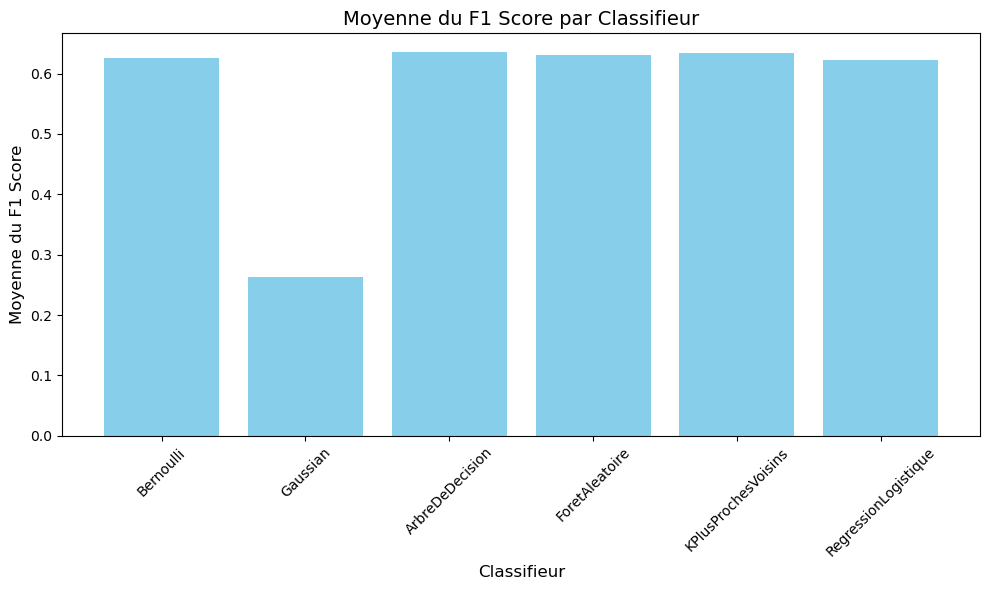

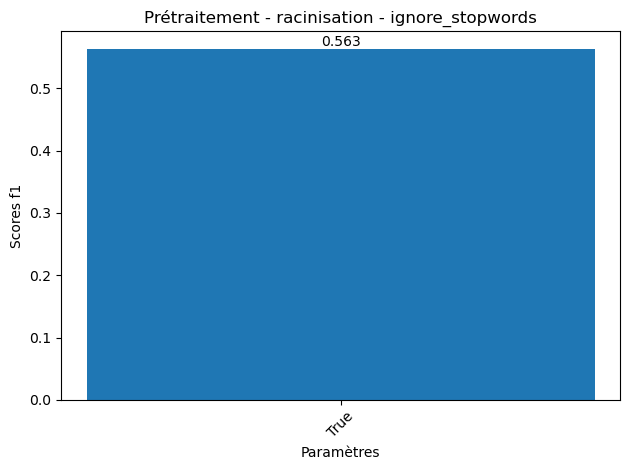

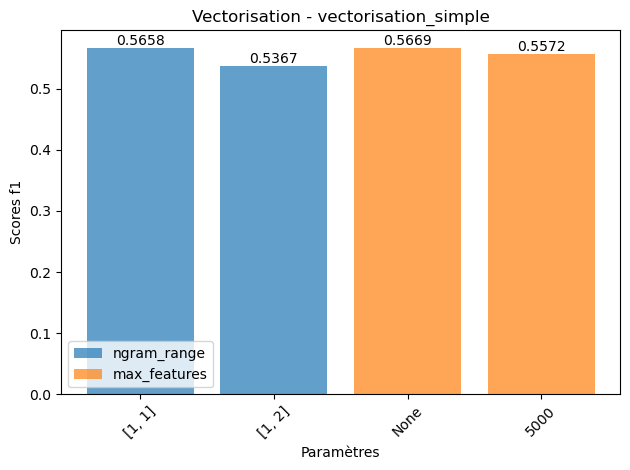

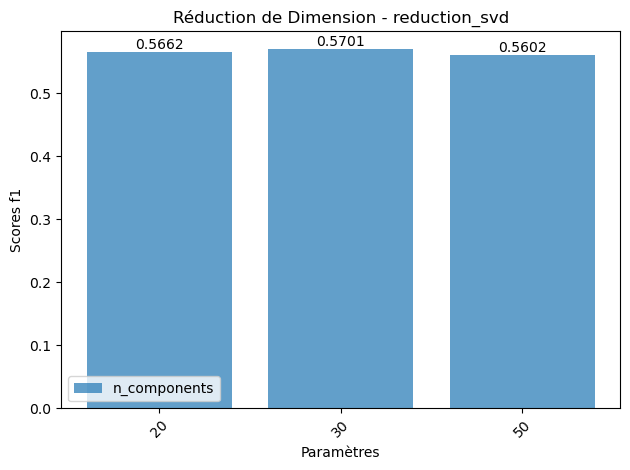

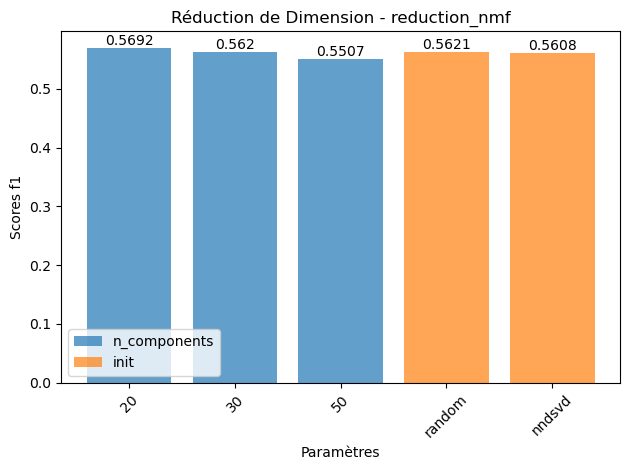

In [17]:
class Analyse():

    def __init__(self):
        self.dossier = "Résultat"

        self.charger_total()  #self.total

        self.nb_individus = len(self.total)

        self.classifiers = set([str(entry["classifieur_name"]) for entry in self.total])





    def charger_total(self):
        self.total = []
        for fichier in os.listdir(self.dossier):
            chemin_fichier = os.path.join(self.dossier, fichier)
            
            if os.path.isfile(chemin_fichier):
                with open(chemin_fichier, 'r', encoding='utf-8') as f:
                    try:
                        data = json.load(f)
                        if isinstance(data, list) and all(isinstance(item, dict) for item in data):
                            self.total.extend(data)
                        else:
                            print(f"Avertissement : {fichier} ne contient pas une liste de dictionnaires.")
                    except json.JSONDecodeError as e:
                        print(f"Erreur lors de la lecture de {fichier} : {e}")

    def comparaison_classifieur(self):

        scores = {}
        counts = {}

        for entry in self.total:
            classifieur = entry['classifieur_name']
            f1_score = float(entry['f1_score'])

            if classifieur not in scores:
                scores[classifieur] = 0
                counts[classifieur] = 0

            scores[classifieur] += f1_score
            counts[classifieur] += 1

        # Calculer les moyennes
        mean_scores = {classifieur: scores[classifieur] / counts[classifieur] for classifieur in scores}

        # Préparer les données pour le graphique
        classifieurs = list(mean_scores.keys())
        mean_values = list(mean_scores.values())

        # Tracer le graphique
        plt.figure(figsize=(10, 6))
        plt.bar(classifieurs, mean_values, color='skyblue')
        plt.xlabel('Classifieur', fontsize=12)
        plt.ylabel('Moyenne du F1 Score', fontsize=12)
        plt.title('Moyenne du F1 Score par Classifieur', fontsize=14)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()



    def comparaison_classifieur_parametres(self,classifier_name):
        res = {}
        # Initialisation des listes pour stocker les paramètres et scores F1
        for individu in self.total : 
            if individu["classifieur_name"] == classifier_name : 
                for key,value in individu["best_param"].items():
                    if key in res : 
                        if value in res[key] : res[key][value].append(individu["f1_score"])
                        else : res[key][value] = [individu["f1_score"]]
                    else : res[key] = {value : [individu["f1_score"]]}
        return res
    

    def calculate_averages(self, data):
        averages = {}
        
        # Parcours de chaque paramètre
        for param, values_dict in data.items():
            averages[param] = {}
            
            # Parcours de chaque clé de 'values_dict' (par exemple, 0.1, 0.5, True)
            for key, value_list in values_dict.items():
                # Convertir les valeurs en flottants et calculer la moyenne
                float_values = [float(v) for v in value_list]
                averages[param][key] = sum(float_values) / len(float_values)
        
        return averages
    
    def graph_param_classifieur(self):
        for classifieur in self.classifiers : 
            param_dict = self.calculate_averages(self.comparaison_classifieur_parametres(classifieur))

            params = []
            values = []
            
            # Collecter les paramètres et leurs valeurs
            for param, sub_dict in param_dict.items():
                for key, value in sub_dict.items():
                    params.append(f'{param} = {key}')
                    values.append(value)
            
            # Création du graphique
            plt.figure(figsize=(10, 6))
            plt.bar(params, values, color='skyblue')
            bars = plt.bar(params, values, color='skyblue')
            
            for bar in bars:
                yval = bar.get_height()  # Hauteur de la barre
                plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), ha='center', va='bottom', fontsize=10)

            # Personnalisation du graphique
            plt.title(classifieur, fontsize=14)
            plt.xlabel('Paramètres', fontsize=12)
            plt.ylabel('Valeur F1_score', fontsize=12)
            plt.xticks(rotation=45, ha='right')  # Rotation des labels pour plus de lisibilité
            plt.tight_layout()
            
            # Affichage du graphique
            plt.show()

    def comparaison_methode_parametres(self):
        res = {"preprocessing" : {}, "vectorization" : {}, "dimension_reduction" : {}}
        # Initialisation des listes pour stocker les paramètres et scores F1
        for individu in self.total : 
            for etape in res.keys():
                for key,value in individu[etape]["parameters"].items():
 
                    key = str(key)
                    value = str(value)
                    # Vérification et initialisation des clés à chaque niveau
                    if etape not in res:
                        res[etape] = {}
                    
                    if individu[etape]["method"] not in res[etape]:
                        res[etape][individu[etape]["method"]] = {}
                    
                    if key not in res[etape][individu[etape]["method"]]:
                        res[etape][individu[etape]["method"]][key] = {}
                    
                    if value not in res[etape][individu[etape]["method"]][key]:
                        res[etape][individu[etape]["method"]][key][value] = []

                    # Ajout du score F1
                    res[etape][individu[etape]["method"]][key][value].append(individu["f1_score"])




        return res
    
    def calculate_averages_traitement(self, data):
        # Parcours du dictionnaire pour calculer les moyennes des listes
        for section in data.values():
            for sub_section in section.values():
                for key, value in sub_section.items():
                    for sub_key, value_list in value.items():
                        # Calcul de la moyenne des scores F1 pour chaque combinaison de paramètre
                        if isinstance(value_list, list):
                            sub_section[key][sub_key] = sum(float(x) for x in value_list) / len(value_list)
        return data

    def graph_param_traitement(self):

        data_dict = self.calculate_averages_traitement(self.comparaison_methode_parametres())

        preprocessing_data = data_dict.get('preprocessing', {})
        if preprocessing_data:
            for key, value in preprocessing_data.items():
                for sub_key, sub_value in value.items():
                    # On suppose qu'il n'y a qu'une seule entrée sous 'ignore_stopwords'
                    plt.figure()
                    bars = plt.bar(sub_value.keys(), sub_value.values())
                    plt.xlabel('Paramètres')
                    plt.ylabel('Scores f1')
                    plt.title(f'Prétraitement - {key} - {sub_key}')
                    plt.xticks(rotation=45)
                    
                    # Ajouter les étiquettes sur les barres
                    for bar in bars:
                        yval = bar.get_height()
                        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4),
                                ha='center', va='bottom', fontsize=10)  # Étiquette au-dessus de la barre
                    
                    plt.tight_layout()
                    plt.show()

        # Niveau 2 : Pour 'vectorization'
        vectorization_data = data_dict.get('vectorization', {})
        if vectorization_data:
            for key, value in vectorization_data.items():
                # Combiner les données des derniers niveaux dans un seul graphique
                plt.figure()
                for sub_key, sub_value in value.items():
                    bars = plt.bar(sub_value.keys(), sub_value.values(), label=sub_key, alpha=0.7)
                    
                    # Ajouter les étiquettes sur les barres pour chaque série
                    for bar in bars:
                        yval = bar.get_height()
                        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4),
                                ha='center', va='bottom', fontsize=10)  # Étiquette au-dessus de la barre
                    
                plt.xlabel('Paramètres')
                plt.ylabel('Scores f1')
                plt.title(f'Vectorisation - {key}')
                plt.legend()
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

        # Niveau 3 : Pour 'dimension_reduction'
        dimension_reduction_data = data_dict.get('dimension_reduction', {})
        if dimension_reduction_data:
            for key, value in dimension_reduction_data.items():
                # Combiner les données des derniers niveaux dans un seul graphique
                plt.figure()
                for sub_key, sub_value in value.items():
                    bars = plt.bar(sub_value.keys(), sub_value.values(), label=sub_key, alpha=0.7)
                    
                    # Ajouter les étiquettes sur les barres pour chaque série
                    for bar in bars:
                        yval = bar.get_height()
                        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4),
                                ha='center', va='bottom', fontsize=10)  # Étiquette au-dessus de la barre
                    
                plt.xlabel('Paramètres')
                plt.ylabel('Scores f1')
                plt.title(f'Réduction de Dimension - {key}')
                plt.legend()
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()


analyse = Analyse()
analyse.comparaison_classifieur()
analyse.graph_param_traitement()

En lançant, les graphiques on remarque un plafond de verre où la plupart des classifieurs ont un f1 score de 64%.

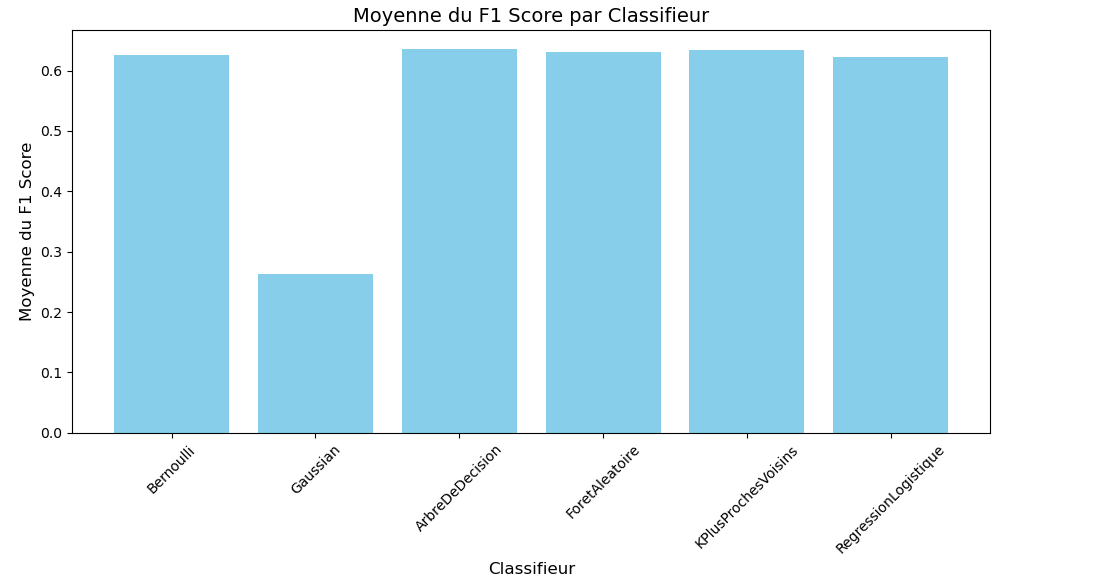

### Matrice de confusion

In [ ]:
data = Data()
data.lemmatisation()
data.vectorisation_ponderee()
data.reduction_nmf(n_components=30)
data_train=data.get_data()

foret = ForetAleatoire(data_train)
foret.entrainement()
print(foret.f1_score(graph=True))

Pour évaluer la performance du modèle, nous avons choisi de construire une matrice de confusion. Le classifieur utilisé est la forêt aléatoire, car il a montré de bons résultats dans des scénarios similaires.

En observant la matrice de confusion, nous constatons que le modèle réussit à prédire la classe  0  (annonces acceptées), mais peine à identifier correctement la classe  1  (annonces rejetées). Cela suggère que le modèle rejette trop peu d'annonces.

Nous pensons que cela est dû à un prétraitement insuffisant des données, qui ne fournit pas des critères suffisamment discriminants pour bien identifier les annonces à rejeter.

### Analyse thématique

In [ ]:
data = Data()
data.lemmatisation()
data.vectorisation_simple()

data_thematique = data.get_data()
data_thematique=data_thematique[data_thematique.max().sort_values(ascending=True).index].iloc[:, -15:]
data_thematique["cal_réponse_signalement" ] = data.get_data()[ "cal_réponse_signalement" ]

tableau_double_entree = data_thematique.groupby( "cal_réponse_signalement" ).sum()

# Créer la heatmap
plt.figure(figsize=(12, 8))  # Taille de l'image
sns.heatmap(tableau_double_entree, annot=True, cmap= "YlGnBu" , fmt= "d" , cbar=True)

# Ajouter des titres et labels pour la heatmap
plt.title( "Matrice de fréquence des mots selon la modalité de cal_réponse_signalement" )
plt.xlabel( "Mots")
plt.ylabel( "Modalités de cal_réponse_signalement" )

# Afficher la heatmap
plt.show()

tableau_normalise = tableau_double_entree.div(tableau_double_entree.sum(axis=0), axis=1) * 100

# Créer le graphique à barres horizontales 100% pour chaque mot
plt.figure(figsize=(12, 8))
ax = tableau_normalise.T.plot(kind='barh', stacked=True, width=0.8, color=sns.color_palette( "Set2", len(tableau_normalise)), legend=False)

plt.title( "Répartition des mots par modalités de cal_réponse_signalement (%)" )
plt.xlabel( "Pourcentage (%)" )
plt.ylabel( "Mots" )
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.1f}%' for v in container.datavalues], label_type= "center" )

plt.show()

Au début du projet, nous avons supposé que le pré-traitement des données devait être amélioré pour mieux distinguer les annonces gardées et rejetées. Initialement, nous avons basé notre analyse sur l'hypothèse que l'annonce elle-même pouvait définir la classe. Nous avons donc choisi de ne prendre en compte que la colonne texte_annonce, en négligeant les autres variables. Après avoir effectué une lemmatisation et une vectorisation simple, nous avons généré un tableau à double entrée pour observer la fréquence des mots selon les deux modalités : annonce gardée et annonce rejetée.

Nous constatons que le mot le plus fréquent dans les annonces est  marché , un terme qui apparaît particulièrement souvent dans les annonces gardées. De plus, la plupart des mots les plus fréquents dans le tableau sont également ceux qui sont prédominants dans les annonces gardées. Cela renforce notre hypothèse initiale selon laquelle le pré-traitement des données ne fournit pas des valeurs discriminantes suffisantes pour bien différencier les deux classes (annonces gardées et annonces rejetées).

Ensuite, nous avons tracé un graphique pour analyser la répartition des mots par modalité. Les résultats montrent que les mots les plus fréquents sont dominés par ceux des annonces gardées, ce qui suggère que le modèle rencontre des difficultés à détecter les caractéristiques spécifiques aux annonces rejetées.

## Conclusion

Dans le cadre de cette SAE, nous avons réussi à repenser la structure de notre projet en nous appuyant sur les retours du TP noté précédemment. En observant les limites de l'approche initiale, notamment l'utilisation excessive de copier-coller, nous avons choisi d'adopter une architecture plus flexible et modulaire, facilitant ainsi les tests de différentes hypothèses et configurations.

L'approche orientée objet que nous avons mise en place, centrée autour de quatre classes principales (Data, Classifieur, les différents classifieurs, et Projet), a permis de mieux répartir les tâches et de travailler de manière plus indépendante. Cette organisation a amélioré l’optimisation du projet mais a également simplifié l'exploration des hyperparamètres et la gestion des différentes étapes du pipeline.

Cependant, nos analyses de la matrice de confusion et de la répartition des mots par modalité ont révélé que le pré-traitement des données était insuffisant pour offrir une différenciation adéquate entre les annonces acceptées et rejetées. Le manque de discriminabilité des caractéristiques extraites a conduit à des résultats peu équilibrés, avec une prédiction correcte des annonces acceptées mais une identification faible des annonces rejetées. Ces résultats montrent que des améliorations du pré-traitement, en enrichissant les caractéristiques sont nécessaires pour mieux modéliser les données.

En conclusion, bien que la structure du projet ait montré des bénéfices en termes de flexibilité et de compréhension, des ajustements dans la préparation des données et la sélection des caractéristiques sont essentiels pour améliorer les performances du modèle, en particulier pour mieux différencier les annonces rejetées des annonces acceptées.